In [2]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from collections import namedtuple, deque
from itertools import count
from IPython.display import clear_output
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

is_ipython = 'inline' in matplotlib.get_backend()

Complete


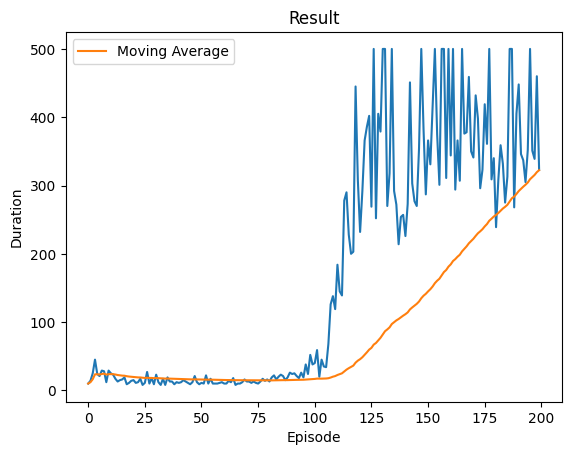

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
env = gym.make("CartPole-v1", render_mode="human")

plt.ion()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Replay Memory class
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions and observations
n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)

# Neural networks and optimizer
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

# List to store durations
episode_durations = []

# Lists to store state dimension values
state_dim1_values = []
state_dim2_values = []
state_dim3_values = []
state_dim4_values = []

steps_done = 0

# Function to select an action
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def moving_average(data, window_size):
    moving_avg = np.empty_like(data)
    for i in range(len(data)):
        if i < window_size:
            moving_avg[i] = data[:i+1].mean()
        else:
            moving_avg[i] = data[i-window_size+1:i+1].mean()
    return moving_avg

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    moving_avg = moving_average(durations_t.numpy(), 100)
    plt.plot(moving_avg, label='Moving Average')
    
    plt.legend()
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# Function to train the network
def train_net():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main loop
num_episodes = 200
max_episode_steps = 5000
# List to store durations
episode_durations = []
state_dim1_actions_0 = []
state_dim2_actions_0 = []
state_dim3_actions_0 = []
state_dim4_actions_0 = []
state_dim1_actions_1 = []
state_dim2_actions_1 = []
state_dim3_actions_1 = []
state_dim4_actions_1 = []

# Main loop
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    last_state_dim1_actions_0 = []
    last_state_dim2_actions_0 = []
    last_state_dim3_actions_0 = []
    last_state_dim4_actions_0 = []
    last_state_dim1_actions_1 = []
    last_state_dim2_actions_1 = []
    last_state_dim3_actions_1 = []
    last_state_dim4_actions_1 = []
    for t in range(max_episode_steps):
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # Append the state values to the respective lists
        dim1, dim2, dim3, dim4 = state.squeeze().tolist()
        if action.item() == 0:
            state_dim1_actions_0.append(dim1)
            state_dim2_actions_0.append(dim2)
            state_dim3_actions_0.append(dim3)
            state_dim4_actions_0.append(dim4)
            
            last_state_dim1_actions_0.append(dim1)
            last_state_dim2_actions_0.append(dim2)
            last_state_dim3_actions_0.append(dim3)
            last_state_dim4_actions_0.append(dim4)
        elif action.item() == 1:
            state_dim1_actions_1.append(dim1)
            state_dim2_actions_1.append(dim2)
            state_dim3_actions_1.append(dim3)
            state_dim4_actions_1.append(dim4)
            
            last_state_dim1_actions_1.append(dim1)
            last_state_dim2_actions_1.append(dim2)
            last_state_dim3_actions_1.append(dim3)
            last_state_dim4_actions_1.append(dim4)


        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        train_net()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            if (i_episode + 1) % 10 == 0:  # Update plot every 10 episodes
                plot_durations()
            break
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

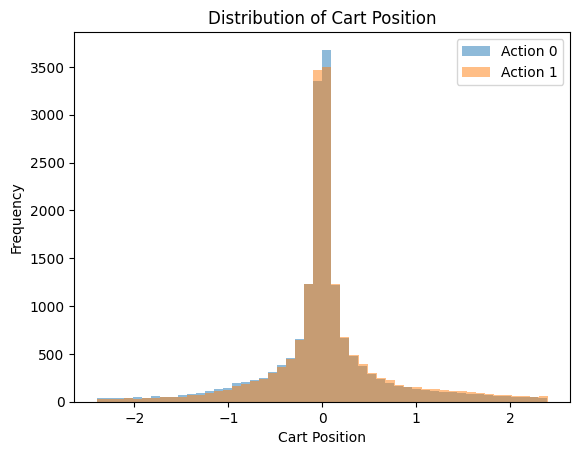

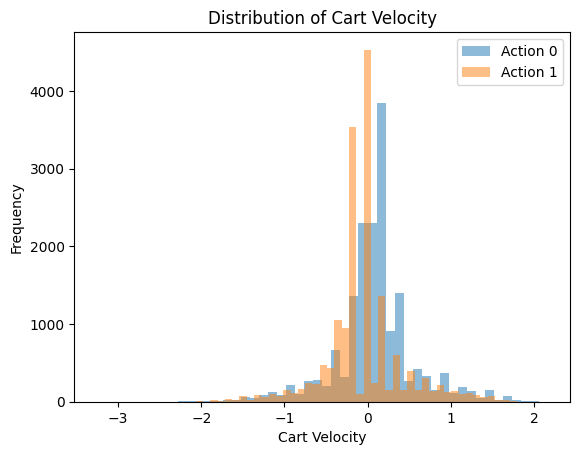

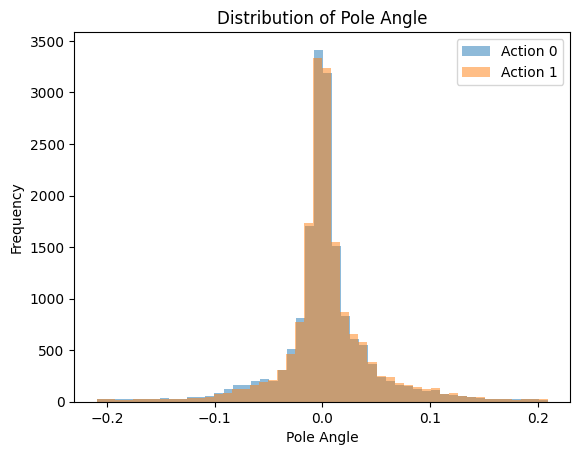

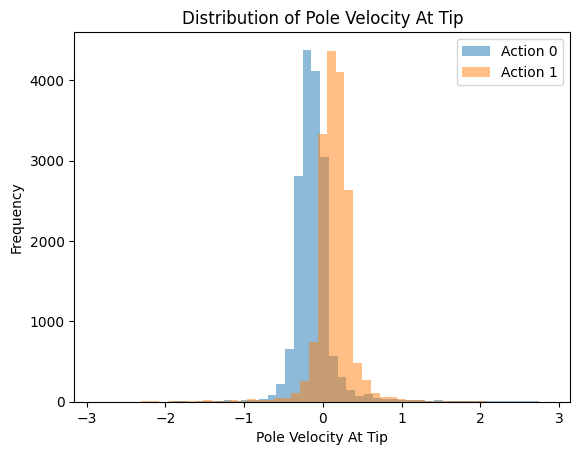

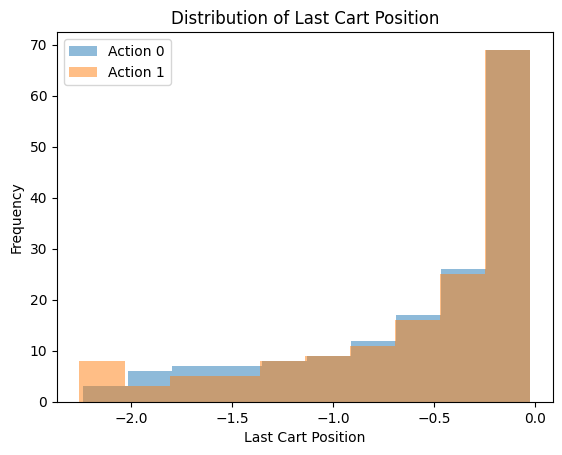

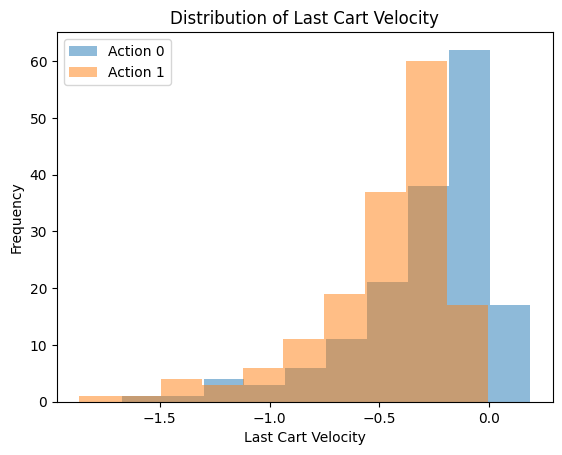

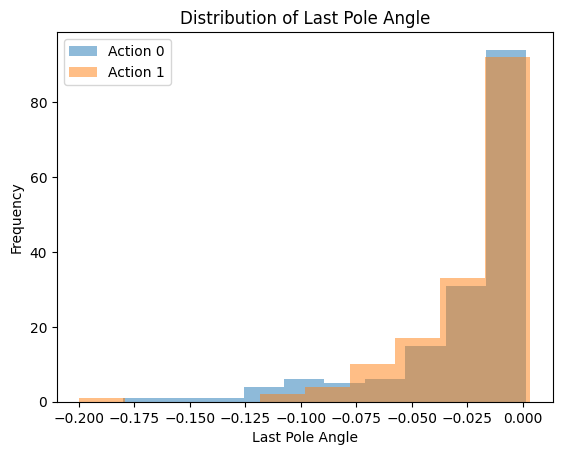

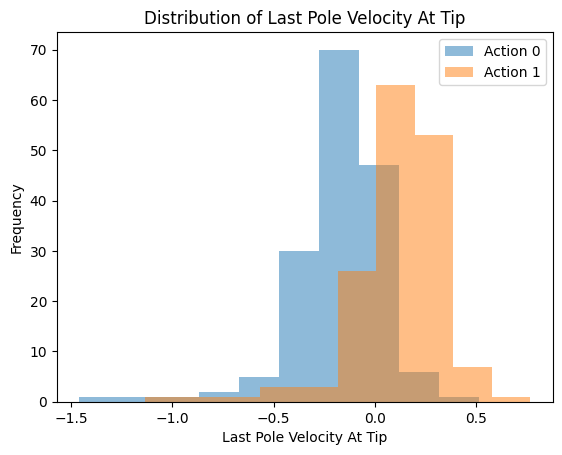

In [4]:
# At the end of training, plot the distributions for each state dimension
plt.figure()
plt.hist(state_dim1_actions_0, bins=50, alpha=0.5, label='Action 0')
plt.hist(state_dim1_actions_1, bins=50, alpha=0.5, label='Action 1')
plt.title('Distribution of Cart Position')
plt.xlabel('Cart Position')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure()
plt.hist(state_dim2_actions_0, bins=50, alpha=0.5, label='Action 0')
plt.hist(state_dim2_actions_1, bins=50, alpha=0.5, label='Action 1')
plt.title('Distribution of Cart Velocity')
plt.xlabel('Cart Velocity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure()
plt.hist(state_dim3_actions_0, bins=50, alpha=0.5, label='Action 0')
plt.hist(state_dim3_actions_1, bins=50, alpha=0.5, label='Action 1')
plt.title('Distribution of Pole Angle')
plt.xlabel('Pole Angle')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure()
plt.hist(state_dim4_actions_0, bins=50, alpha=0.5, label='Action 0')
plt.hist(state_dim4_actions_1, bins=50, alpha=0.5, label='Action 1')
plt.title('Distribution of Pole Velocity At Tip')
plt.xlabel('Pole Velocity At Tip')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Now, for the last state distributions:

plt.figure()
plt.hist(last_state_dim1_actions_0, bins=10, alpha=0.5, label='Action 0')
plt.hist(last_state_dim1_actions_1, bins=10, alpha=0.5, label='Action 1')
plt.title('Distribution of Last Cart Position')
plt.xlabel('Last Cart Position')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure()
plt.hist(last_state_dim2_actions_0, bins=10, alpha=0.5, label='Action 0')
plt.hist(last_state_dim2_actions_1, bins=10, alpha=0.5, label='Action 1')
plt.title('Distribution of Last Cart Velocity')
plt.xlabel('Last Cart Velocity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure()
plt.hist(last_state_dim3_actions_0, bins=10, alpha=0.5, label='Action 0')
plt.hist(last_state_dim3_actions_1, bins=10, alpha=0.5, label='Action 1')
plt.title('Distribution of Last Pole Angle')
plt.xlabel('Last Pole Angle')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure()
plt.hist(last_state_dim4_actions_0, bins=10, alpha=0.5, label='Action 0')
plt.hist(last_state_dim4_actions_1, bins=10, alpha=0.5, label='Action 1')
plt.title('Distribution of Last Pole Velocity At Tip')
plt.xlabel('Last Pole Velocity At Tip')
plt.ylabel('Frequency')
plt.legend()
plt.show()
